In [ ]:
# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. Unzip AffectNet if needed
import zipfile, os

zip_path = '/content/drive/MyDrive/affectnet.zip'  # <- Update if needed
extract_path = '/content/affectnet'

if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

# 3. Imports
import torch, torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 4. Dataset Class with Face Cropping using YOLO labels
class AffectNetDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transform=None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transform = transform
        self.image_files = sorted([
            f for f in os.listdir(images_dir)
            if f.endswith('.jpg') or f.endswith('.png')
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.images_dir, img_name)
        label_path = os.path.join(self.labels_dir, img_name.replace('.jpg', '.txt').replace('.png', '.txt'))

        image = Image.open(img_path).convert('RGB')
        width, height = image.size

        # Parse YOLO label
        with open(label_path, 'r') as f:
            line = f.readline().strip()
            parts = line.split()
            class_id = int(parts[0])
            x_center = float(parts[1]) * width
            y_center = float(parts[2]) * height
            box_width = float(parts[3]) * width
            box_height = float(parts[4]) * height

            left = int(x_center - box_width / 2)
            top = int(y_center - box_height / 2)
            right = int(x_center + box_width / 2)
            bottom = int(y_center + box_height / 2)

            image = image.crop((left, top, right, bottom))

        if self.transform:
            image = self.transform(image)

        return image, class_id

# 5. Image transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# 6. Paths
base_path = '/content/affectnet/YOLO_format'
train_images = f'{base_path}/train/images'
train_labels = f'{base_path}/train/labels'
valid_images = f'{base_path}/valid/images'
valid_labels = f'{base_path}/valid/labels'
test_images = f'{base_path}/test/images'
test_labels = f'{base_path}/test/labels'

# 7. Datasets and loaders
train_dataset = AffectNetDataset(train_images, train_labels, transform)
valid_dataset = AffectNetDataset(valid_images, valid_labels, transform)
test_dataset = AffectNetDataset(test_images, test_labels, transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# 8. Model: ResNet18
num_classes = 8  # Change this based on your dataset
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

# 9. Loss & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# 10. Train/Val Functions
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, total_correct = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
        total_correct += (out.argmax(1) == y).sum().item()
    return total_loss / len(loader.dataset), total_correct / len(loader.dataset)

def eval_model(model, loader, criterion):
    model.eval()
    total_loss, total_correct = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            total_loss += loss.item() * x.size(0)
            total_correct += (out.argmax(1) == y).sum().item()
    return total_loss / len(loader.dataset), total_correct / len(loader.dataset)

#training loop
# Initialize lists to store metrics
train_losses = []
train_accs = []
val_losses = []
val_accs = []

epochs = 10
for epoch in range(epochs):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = eval_model(model, valid_loader, criterion)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")

# Plot loss curves
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plot accuracy curves
plt.subplot(1,2,2)
plt.plot(range(1, epochs+1), train_accs, label='Train Accuracy')
plt.plot(range(1, epochs+1), val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.show()

# Final test accuracy
test_loss, test_acc = eval_model(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")



Mounted at /content/drive


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 160MB/s]


In [ ]:
# Save the trained model (assuming training cell was already run)
save_path = '/content/drive/MyDrive/affectnet_resnet18.pth'
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")


Model saved to /content/drive/MyDrive/affectnet_resnet18.pth


In [ ]:
from google.colab import drive
import zipfile
import os

# Mount Drive
drive.mount('/content/drive')

# Path to ZIP
zip_path = '/content/drive/MyDrive/ravdess.zip'  # change if needed
extract_path = '/content/ravdess'

# Extract if not already done
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import glob

wav_files = glob.glob(os.path.join(extract_path, 'Actor_*', '*.wav'))
print(f'Total audio files: {len(wav_files)}')
print(f'Sample file: {wav_files[0]}')


Total audio files: 1440
Sample file: /content/ravdess/Actor_23/03-01-04-01-02-01-23.wav


In [ ]:
def extract_emotion(file_path):
    file_name = os.path.basename(file_path)
    emotion_id = int(file_name.split('-')[2])
    return emotion_id - 1  # Convert to 0-based indexing (0–7)


In [ ]:
import librosa
import numpy as np

def extract_features(file_path, n_mfcc=40):
    y, sr = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfccs_mean = np.mean(mfccs.T, axis=0)
    return mfccs_mean


In [ ]:
X, y = [], []

for file_path in wav_files:
    features = extract_features(file_path)
    label = extract_emotion(file_path)
    X.append(features)
    y.append(label)

X = np.array(X)
y = np.array(y)
print("Feature shape:", X.shape, "Label shape:", y.shape)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


In [ ]:
import joblib

save_path = '/content/drive/MyDrive/ravdess_emotion_model.pkl'
joblib.dump(clf, save_path)
print(f"Model saved to {save_path}")


In [8]:
!unzip -q "/content/drive/MyDrive/affectnet.zip" -d "/content/drive/MyDrive/affectnet_unzipped"
!ls "/content/drive/MyDrive/affectnet_unzipped/YOLO_format/train/images" | head


ffhq_0.png
ffhq_1000.png
ffhq_1001.png
ffhq_1003.png
ffhq_1004.png
ffhq_1005.png
ffhq_1007.png
ffhq_1008.png
ffhq_1009.png
ffhq_100.png


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.14.0
Epoch 1/10: 100%|██████████| 1521/1521 [04:43<00:00,  5.36it/s, Loss=1.79, Acc=16.68%]



✅ Epoch 1 | Loss: 1.9947 | Accuracy: 0.1668


Epoch 2/10: 100%|██████████| 1521/1521 [02:36<00:00,  9.73it/s, Loss=2.06, Acc=17.15%]



✅ Epoch 2 | Loss: 1.9876 | Accuracy: 0.1715


Epoch 3/10: 100%|██████████| 1521/1521 [02:35<00:00,  9.81it/s, Loss=1.88, Acc=18.08%]



✅ Epoch 3 | Loss: 1.9839 | Accuracy: 0.1808


Epoch 4/10: 100%|██████████| 1521/1521 [02:35<00:00,  9.76it/s, Loss=1.99, Acc=17.88%]



✅ Epoch 4 | Loss: 1.9843 | Accuracy: 0.1788


Epoch 5/10: 100%|██████████| 1521/1521 [02:38<00:00,  9.59it/s, Loss=2.13, Acc=17.71%]



✅ Epoch 5 | Loss: 1.9838 | Accuracy: 0.1771


Epoch 6/10: 100%|██████████| 1521/1521 [02:35<00:00,  9.80it/s, Loss=2.12, Acc=18.17%]



✅ Epoch 6 | Loss: 1.9794 | Accuracy: 0.1817


Epoch 7/10: 100%|██████████| 1521/1521 [02:34<00:00,  9.82it/s, Loss=1.88, Acc=18.21%]



✅ Epoch 7 | Loss: 1.9788 | Accuracy: 0.1821


Epoch 8/10: 100%|██████████| 1521/1521 [02:35<00:00,  9.78it/s, Loss=1.92, Acc=18.48%]



✅ Epoch 8 | Loss: 1.9773 | Accuracy: 0.1848


Epoch 9/10: 100%|██████████| 1521/1521 [02:35<00:00,  9.79it/s, Loss=1.97, Acc=18.29%]



✅ Epoch 9 | Loss: 1.9789 | Accuracy: 0.1829


Epoch 10/10: 100%|██████████| 1521/1521 [02:34<00:00,  9.84it/s, Loss=1.99, Acc=18.49%]



✅ Epoch 10 | Loss: 1.9775 | Accuracy: 0.1849


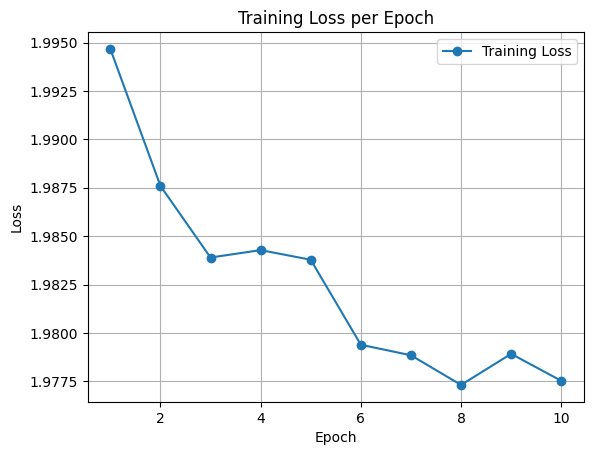

In [9]:
# 📂 Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 📦 Imports
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchvision.models import resnet18
import joblib
import librosa
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# 💻 Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 🧠 Load AffectNet (ResNet18)
affectnet_model = torch.hub.load('pytorch/vision:v0.14.0', 'resnet18', pretrained=False)
affectnet_model.fc = nn.Linear(affectnet_model.fc.in_features, 8)
affectnet_model.load_state_dict(torch.load('/content/drive/MyDrive/affectnet_resnet18.pth'))
affectnet_model.to(device)
affectnet_model.eval()

# 🎧 Load RAVDESS Random Forest Model
ravdess_model = joblib.load('/content/drive/MyDrive/ravdess_emotion_model.pkl')

# 📊 Audio embedding function
def get_ravdess_embedding(filepath):
    y, sr = librosa.load(filepath, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfccs = mfccs.mean(axis=1)
    pred = ravdess_model.predict_proba([mfccs])[0]
    return torch.tensor(pred, dtype=torch.float32)

# 🧷 AffectNet Dataset (YOLO format)
class AffectNetYOLODataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.images = [f for f in os.listdir(image_dir) if f.endswith(".jpg")]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        label_path = os.path.join(self.label_dir, img_name.replace('.jpg', '.txt'))

        with open(label_path, 'r') as f:
            label = int(f.readline().split()[0])

        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        return 'affectnet', image, label

# 🧷 RAVDESS Dataset
class RAVDESSDataset(Dataset):
    def __init__(self, base_dir, label_map):
        self.samples = []
        for root, _, files in os.walk(base_dir):
            for file in files:
                if file.endswith('.wav'):
                    label = int(file.split('-')[2]) - 1  # Emotion ID is 3rd field (starts at 1)
                    self.samples.append((os.path.join(root, file), label))
        self.label_map = label_map

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        return 'ravdess', path, label

# 🚀 Combine Datasets
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

affectnet_path = "/content/drive/MyDrive/affectnet_unzipped/YOLO_format/train"
affectnet_dataset = AffectNetYOLODataset(
    image_dir=os.path.join(affectnet_path, "images"),
    label_dir=os.path.join(affectnet_path, "labels"),
    transform=transform
)


ravdess_dataset = RAVDESSDataset("/content/drive/MyDrive/ravdess", label_map=None)

# 🧃 Merge into one dataset
class FusionDataset(Dataset):
    def __init__(self, affectnet_dataset, ravdess_dataset):
        self.data = affectnet_dataset + ravdess_dataset

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

fusion_dataset = FusionDataset(affectnet_dataset, ravdess_dataset)
fusion_loader = DataLoader(fusion_dataset, batch_size=8, shuffle=True)

# 🔁 Fusion Model
class FusionModel(nn.Module):
    def __init__(self, affectnet_model, ravdess_model_embedding_size=8, fusion_hidden_dim=128, num_classes=8):
        super(FusionModel, self).__init__()
        self.affectnet_model = affectnet_model
        self.ravdess_embedding_size = ravdess_model_embedding_size

        for param in self.affectnet_model.parameters():
            param.requires_grad = False
        self.affectnet_model.fc = nn.Identity()

        self.ravdess_fc = nn.Sequential(
            nn.Linear(ravdess_model_embedding_size, 64),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        self.fusion_fc = nn.Sequential(
            nn.Linear(512 + 64, fusion_hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(fusion_hidden_dim, num_classes)
        )

    def forward(self, source, x):
        if source == 'affectnet':
            emb = self.affectnet_model(x)
            audio_emb = torch.zeros(x.size(0), self.ravdess_embedding_size).to(x.device)
        else:
            emb = torch.zeros(x.size(0), 512).to(x.device)
            audio_emb = x

        audio_emb = self.ravdess_fc(audio_emb)
        fused = torch.cat((emb.view(emb.size(0), -1), audio_emb.view(audio_emb.size(0), -1)), dim=1)
        return self.fusion_fc(fused)

# 🧠 Train Fusion Model with Early Stopping
fusion_model = FusionModel(affectnet_model).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fusion_model.parameters(), lr=1e-4)
num_epochs = 10
early_stop_patience = 3
best_loss = float('inf')
no_improve = 0
train_losses = []

for epoch in range(num_epochs):
    fusion_model.train()
    epoch_loss = 0.0
    correct, total = 0, 0
    progress_bar = tqdm(fusion_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for source, datas, labels in progress_bar:
        optimizer.zero_grad()
        labels = labels.to(device)
        outputs = []

        for i in range(len(source)):
            if source[i] == 'affectnet':
                img = datas[i].to(device)
                out = fusion_model('affectnet', img.unsqueeze(0))
            else:
                emb = get_ravdess_embedding(datas[i]).to(device)
                out = fusion_model('ravdess', emb.unsqueeze(0))
            outputs.append(out)

        outputs = torch.cat(outputs, dim=0)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        epoch_loss += loss.item()

        progress_bar.set_postfix({"Loss": loss.item(), "Acc": f"{100 * correct / total:.2f}%"})

    avg_loss = epoch_loss / len(fusion_loader)
    train_losses.append(avg_loss)
    print(f"\n✅ Epoch {epoch+1} | Loss: {avg_loss:.4f} | Accuracy: {correct/total:.4f}")

    if avg_loss < best_loss:
        best_loss = avg_loss
        no_improve = 0
        torch.save(fusion_model.state_dict(), "/content/best_fusion_model.pth")
    else:
        no_improve += 1
        if no_improve >= early_stop_patience:
            print("🛑 Early stopping triggered.")
            break

# 📈 Plot Loss
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.grid(True)
plt.legend()
plt.show()


In [6]:
# 📂 Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 📦 Imports
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet18
import joblib
import librosa
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# 💻 Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 🧠 Load AffectNet (ResNet18)
affectnet_model = torch.hub.load('pytorch/vision:v0.14.0', 'resnet18', pretrained=False)
affectnet_model.fc = nn.Linear(affectnet_model.fc.in_features, 8)
affectnet_model.load_state_dict(torch.load('/content/drive/MyDrive/affectnet_resnet18.pth'))
affectnet_model.to(device)
affectnet_model.eval()

# 🎧 Load RAVDESS Random Forest Model
ravdess_model = joblib.load('/content/drive/MyDrive/ravdess_emotion_model.pkl')

# 📊 Dummy RAVDESS embedding function (replace with yours if needed)
def get_ravdess_embedding(filepath):
    y, sr = librosa.load(filepath, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfccs = mfccs.mean(axis=1)
    pred = ravdess_model.predict_proba([mfccs])[0]
    return torch.tensor(pred, dtype=torch.float32)

# 🔁 Fusion Model
class FusionModel(nn.Module):
    def __init__(self, affectnet_model, ravdess_model_embedding_size=8, fusion_hidden_dim=128, num_classes=8):
        super(FusionModel, self).__init__()
        self.affectnet_model = affectnet_model
        self.ravdess_embedding_size = ravdess_model_embedding_size

        for param in self.affectnet_model.parameters():
            param.requires_grad = False
        self.affectnet_model.fc = nn.Identity()

        self.ravdess_fc = nn.Sequential(
            nn.Linear(ravdess_model_embedding_size, 64),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        self.fusion_fc = nn.Sequential(
            nn.Linear(512 + 64, fusion_hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(fusion_hidden_dim, num_classes)
        )

    def forward(self, source, x):
        if source == 'affectnet':
            emb = self.affectnet_model(x)
            audio_emb = torch.zeros(x.size(0), self.ravdess_embedding_size).to(x.device)
        else:
            emb = torch.zeros(x.size(0), 512).to(x.device)
            audio_emb = x

        audio_emb = self.ravdess_fc(audio_emb)
        fused = torch.cat((emb.view(emb.size(0), -1), audio_emb.view(audio_emb.size(0), -1)), dim=1)
        return self.fusion_fc(fused)

# 🚀 Init Fusion Model
fusion_model = FusionModel(affectnet_model).to(device)

# 🧠 Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fusion_model.parameters(), lr=1e-4)
num_epochs = 10

# ⚠️ Requires: fusion_loader defined externally
train_losses = []

for epoch in range(num_epochs):
    fusion_model.train()
    epoch_loss = 0.0
    correct, total = 0, 0
    progress_bar = tqdm(fusion_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for source, datas, labels in progress_bar:
        optimizer.zero_grad()
        labels = labels.to(device)
        outputs = []

        for i in range(len(source)):
            if source[i] == 'affectnet':
                img = datas[i].to(device)
                out = fusion_model('affectnet', img.unsqueeze(0))
            else:
                emb = get_ravdess_embedding(datas[i]).to(device)
                out = fusion_model('ravdess', emb.unsqueeze(0))
            outputs.append(out)

        outputs = torch.cat(outputs, dim=0)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        epoch_loss += loss.item()

        progress_bar.set_postfix({"Loss": loss.item(), "Acc": f"{100 * correct / total:.2f}%"})

    avg_loss = epoch_loss / len(fusion_loader)
    train_losses.append(avg_loss)
    print(f"\n✅ Epoch {epoch+1} | Loss: {avg_loss:.4f} | Accuracy: {correct/total:.4f}")

# 📈 Plot Training Loss
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.grid(True)
plt.legend()
plt.show()

# 📊 Evaluation Function
def evaluate_fusion_model(model, loader):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for source, datas, labels in tqdm(loader, desc="Evaluating"):
            labels = labels.to(device)
            batch_preds = []

            for i in range(len(source)):
                if source[i] == 'affectnet':
                    img = datas[i].to(device)
                    out = model('affectnet', img.unsqueeze(0))
                else:
                    emb = get_ravdess_embedding(datas[i]).to(device)
                    out = model('ravdess', emb.unsqueeze(0))
                batch_preds.append(out)

            outputs = torch.cat(batch_preds, dim=0)
            _, predicted = torch.max(outputs.data, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    print("\n📊 Classification Report:")
    print(classification_report(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix")
    plt.show()

# ⚠️ Requires: fusion_test_loader defined externally
# evaluate_fusion_model(fusion_model, fusion_test_loader)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.14.0
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Epoch 1/10:   0%|          | 0/1 [00:00<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/affectnet/images/image2.jpg'

In [ ]:
# 📂 Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 📦 Imports and Device Setup
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18
from PIL import Image
import librosa
import numpy as np
import joblib

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 🎯 Load Pretrained AffectNet Model
affectnet_model = torch.hub.load('pytorch/vision:v0.14.0', 'resnet18', pretrained=False)
affectnet_model.fc = nn.Linear(affectnet_model.fc.in_features, 8)  # 8 emotion classes
affectnet_model.load_state_dict(torch.load('/content/drive/MyDrive/affectnet_resnet18.pth'))
affectnet_model.to(device)
affectnet_model.eval()

# 🎧 Load RAVDESS Random Forest Model
ravdess_model = joblib.load('/content/drive/MyDrive/ravdess_emotion_model.pkl')

# 🔁 Define Fusion Model
class FusionModel(nn.Module):
    def __init__(self, affectnet_model, ravdess_model_embedding_size=8, fusion_hidden_dim=128, num_classes=8):
        super(FusionModel, self).__init__()
        self.affectnet_model = affectnet_model
        self.ravdess_embedding_size = ravdess_model_embedding_size
        self.fusion_hidden_dim = fusion_hidden_dim

        # Freeze AffectNet CNN backbone
        for param in self.affectnet_model.parameters():
            param.requires_grad = False
        self.affectnet_model.fc = nn.Identity()  # use features before classifier (512-d)

        # Audio (RAVDESS) embedding projection
        self.ravdess_fc = nn.Sequential(
            nn.Linear(ravdess_model_embedding_size, 64),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Fusion + classifier head
        self.fusion_fc = nn.Sequential(
            nn.Linear(512 + 64, fusion_hidden_dim),  # 512 from image, 64 from audio
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(fusion_hidden_dim, num_classes)
        )

    def forward(self, source, x):
        if source == 'affectnet':
            emb = self.affectnet_model(x)  # shape: [B, 512]
            audio_emb = torch.zeros(x.size(0), self.ravdess_embedding_size).to(x.device)
        else:
            emb = torch.zeros(x.size(0), 512).to(x.device)
            audio_emb = x  # shape: [B, 8]

        audio_emb = self.ravdess_fc(audio_emb)  # shape: [B, 64]
        fused = torch.cat((emb, audio_emb), dim=1)  # shape: [B, 576]
        out = self.fusion_fc(fused)  # shape: [B, 8]
        return out

# 🚀 Instantiate the Fusion Model
fusion_model = FusionModel(affectnet_model, ravdess_model_embedding_size=8)
fusion_model = fusion_model.to(device)
print(f"✅ FusionModel initialized on device: {device}")


In [ ]:
from tqdm import tqdm

num_epochs = 10

fusion_model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    batch_count = 0
    pbar = tqdm(fusion_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for source, datas, label in pbar:
        label = label.to(device)
        optimizer.zero_grad()
        outputs = []
        for i in range(len(source)):
            if source[i] == 'affectnet':
                data = datas[i].to(device)
                out = fusion_model('affectnet', data.unsqueeze(0))
            else:
                mfcc = datas[i]
                emb = get_ravdess_embedding(mfcc).to(device)
                out = fusion_model('ravdess', emb)
            outputs.append(out)
        outputs = torch.cat(outputs, dim=0)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        batch_count += 1
        pbar.set_postfix(loss=running_loss / batch_count)


In [ ]:
torch.save(fusion_model.state_dict(), '/content/drive/MyDrive/fusion_model_final.pth')


In [1]:
# 📂 Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 📦 Imports and Device Setup
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18
from PIL import Image
import librosa
import numpy as np
import joblib

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 🎯 Load Pretrained AffectNet Model
affectnet_model = torch.hub.load('pytorch/vision:v0.14.0', 'resnet18', pretrained=False)
affectnet_model.fc = nn.Linear(affectnet_model.fc.in_features, 8)  # 8 emotion classes
affectnet_model.load_state_dict(torch.load('/content/drive/MyDrive/affectnet_resnet18.pth'))
affectnet_model.to(device)
affectnet_model.eval()

# 🎧 Load RAVDESS Random Forest Model
ravdess_model = joblib.load('/content/drive/MyDrive/ravdess_emotion_model.pkl')

# 🔁 Define Fusion Model
class FusionModel(nn.Module):
    def __init__(self, affectnet_model, ravdess_model_embedding_size=8, fusion_hidden_dim=128, num_classes=8):
        super(FusionModel, self).__init__()
        self.affectnet_model = affectnet_model
        self.ravdess_embedding_size = ravdess_model_embedding_size
        self.fusion_hidden_dim = fusion_hidden_dim

        # Freeze AffectNet CNN backbone
        for param in self.affectnet_model.parameters():
            param.requires_grad = False
        self.affectnet_model.fc = nn.Identity()  # use features before classifier (512-d)

        # Audio (RAVDESS) embedding projection
        self.ravdess_fc = nn.Sequential(
            nn.Linear(ravdess_model_embedding_size, 64),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Fusion + classifier head
        self.fusion_fc = nn.Sequential(
            nn.Linear(512 + 64, fusion_hidden_dim),  # 512 from image, 64 from audio
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(fusion_hidden_dim, num_classes)
        )

    def forward(self, source, x):
        if source == 'affectnet':
            emb = self.affectnet_model(x)  # shape: [B, 512]
            audio_emb = torch.zeros(x.size(0), self.ravdess_embedding_size).to(x.device)
        else:
            emb = torch.zeros(x.size(0), 512).to(x.device)
            audio_emb = x  # shape: [B, 8]

        audio_emb = self.ravdess_fc(audio_emb)  # shape: [B, 64]

        # Flatten to ensure 2D tensors before concatenation
        emb = emb.view(emb.size(0), -1)          # [B, 512]
        audio_emb = audio_emb.view(audio_emb.size(0), -1)  # [B, 64]

        fused = torch.cat((emb, audio_emb), dim=1)  # shape: [B, 576]
        out = self.fusion_fc(fused)  # shape: [B, 8]
        return out

# 🚀 Instantiate the Fusion Model
fusion_model = FusionModel(affectnet_model, ravdess_model_embedding_size=8)
fusion_model = fusion_model.to(device)
print(f"✅ FusionModel initialized on device: {device}")


Mounted at /content/drive


Downloading: "https://github.com/pytorch/vision/zipball/v0.14.0" to /root/.cache/torch/hub/v0.14.0.zip
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


✅ FusionModel initialized on device: cuda


In [2]:
from tqdm import tqdm
import matplotlib.pyplot as plt

train_losses = []

for epoch in range(num_epochs):
    fusion_model.train()
    epoch_loss = 0.0

    progress_bar = tqdm(fusion_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for source, datas, label in progress_bar:
        label = label.to(device)
        optimizer.zero_grad()

        outputs = []
        for i in range(len(source)):
            if source[i] == 'affectnet':
                data = datas[i].to(device)
                output = fusion_model('affectnet', data.unsqueeze(0))
            else:
                emb = get_ravdess_embedding(datas[i]).to(device)
                output = fusion_model('ravdess', emb.unsqueeze(0))
            outputs.append(output)

        outputs = torch.cat(outputs, dim=0)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        progress_bar.set_postfix({"loss": loss.item()})

    avg_loss = epoch_loss / len(fusion_loader)
    train_losses.append(avg_loss)
    print(f"\n✅ Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

# 📈 Plot: Training Loss over Epochs
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.grid(True)
plt.legend()
plt.show()


NameError: name 'num_epochs' is not defined